# Temat 2
Przewidywanie wzięcia pożyczki. Celem projektu jest zastosowanie modeli klasyfikacji (binarnej) do przewidzenia czy pożyczka zostanie udzielona danemu klientowi z danymi parametrami wniosku.

Link do danych:
https://raw.githubusercontent.com/saimadhu-polamuri/DataHakthon3X/master/dataSet/Train.csv <br>
Opis danych (najdokładniejszy jaki istnieje):
https://discuss.analyticsvidhya.com/t/hackathon-3-x-predict-customer-worth-for-happy-customer-bank/3802

Zmienna celu (wypłacenie pożyczki): Disbursed

Wymogi:
- Zmienna LoggedIn nie może być uwzględniona w modelowaniu - należy ją od razu wyrzucić ze zbioru.
- Nie usuwamy żadnych obserwacji - braki danych uzupełniamy w jakiś sposób.
- Wszelkie nieoczywiste przekształcenia danych należy opatrzyć uzasadnieniem dlaczego dokonujemy tego przekształcenia (np. robimy wykres i uzasadniamy wzięci logarytmu ze zmiennej tym, że rozkład jest skośny).
- Należy wykorzystać przynajmniej 3 metody klasyfikacji.
- Należy uwzględnić optymalizację modeli/pipelinów.
- Projekt musi być zakończony przejrzystym porównaniem przetestowanych rozwiązań (modeli/pipelinów) w postaci tabeli, gdzie jeden wiersz opisuje jedno rozwiązanie i jego wynik.

In [1]:
#Import pakietów
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import FeatureUnion
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn import  metrics
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score 
from sklearn.metrics import precision_score 
from sklearn.metrics import accuracy_score 
from sklearn.metrics import balanced_accuracy_score 
from sklearn.metrics import make_scorer

In [2]:
#Import danych
data = pd.read_csv('Train.csv', encoding='ISO-8859–1')

In [3]:
#Podgląd danych
print(data.shape)
print(data.describe())
data.head()

(87020, 26)
       Monthly_Income  Loan_Amount_Applied  Loan_Tenure_Applied  Existing_EMI  \
count    8.702000e+04         8.694900e+04         86949.000000  8.694900e+04   
mean     5.884997e+04         2.302507e+05             2.131399  3.696228e+03   
std      2.177511e+06         3.542068e+05             2.014193  3.981021e+04   
min      0.000000e+00         0.000000e+00             0.000000  0.000000e+00   
25%      1.650000e+04         0.000000e+00             0.000000  0.000000e+00   
50%      2.500000e+04         1.000000e+05             2.000000  0.000000e+00   
75%      4.000000e+04         3.000000e+05             4.000000  3.500000e+03   
max      4.445544e+08         1.000000e+07            10.000000  1.000000e+07   

               Var5  Loan_Amount_Submitted  Loan_Tenure_Submitted  \
count  87020.000000           5.240700e+04           52407.000000   
mean       4.961503           3.950106e+05               3.891369   
std        5.670385           3.082481e+05         

,ID,Gender,City,Monthly_Income,DOB,Lead_Creation_Date,Loan_Amount_Applied,Loan_Tenure_Applied,Existing_EMI,Employer_Name,...,Interest_Rate,Processing_Fee,EMI_Loan_Submitted,Filled_Form,Device_Type,Var2,Source,Var4,LoggedIn,Disbursed
0,ID000002C20,Female,Delhi,20000,23-May-78,15-May-15,300000.0,5.0,0.0,CYBOSOL,...,NaN,NaN,NaN,N,Web-browser,G,S122,1,0,0
1,ID000004E40,Male,Mumbai,35000,07-Oct-85,04-May-15,200000.0,2.0,0.0,TATA CONSULTANCY SERVICES LTD (TCS),...,13.25,NaN,6762.9,N,Web-browser,G,S122,3,0,0
2,ID000007H20,Male,Panchkula,22500,10-Oct-81,19-May-15,600000.0,4.0,0.0,ALCHEMIST HOSPITALS LTD,...,NaN,NaN,NaN,N,Web-browser,B,S143,1,0,0
3,ID000008I30,Male,Saharsa,35000,30-Nov-87,09-May-15,1000000.0,5.0,0.0,BIHAR GOVERNMENT,...,NaN,NaN,NaN,N,Web-browser,B,S143,3,0,0
4,ID000009J40,Male,Bengaluru,100000,17-Feb-84,20-May-15,500000.0,2.0,25000.0,GLOBAL EDGE SOFTWARE,...,NaN,NaN,NaN,N,Web-browser,B,S134,3,1,0


In [4]:
#Wyrzucenie zmiennej LoggedIn
data.drop(columns='LoggedIn', inplace=True)

In [5]:
#Sprawdzenie braków danych
data.isnull().sum()

ID                           0
Gender                       0
City                      1003
Monthly_Income               0
DOB                          0
Lead_Creation_Date           0
Loan_Amount_Applied         71
Loan_Tenure_Applied         71
Existing_EMI                71
Employer_Name               71
Salary_Account           11764
Mobile_Verified              0
Var5                         0
Var1                         0
Loan_Amount_Submitted    34613
Loan_Tenure_Submitted    34613
Interest_Rate            59294
Processing_Fee           59600
EMI_Loan_Submitted       59294
Filled_Form                  0
Device_Type                  0
Var2                         0
Source                       0
Var4                         0
Disbursed                    0
dtype: int64

In [6]:
#Dodanie zmiennej Age (wiek liczony na datę Lead_Creation_Date)
data['Age'] = (pd.to_datetime(data['Lead_Creation_Date']) - pd.to_datetime(data['DOB'])) // np.timedelta64(1, 'Y')
data['Age']

0        36
1        29
2        33
3        27
4        31
         ..
87015   -55
87016    24
87017    43
87018    38
87019    26
Name: Age, Length: 87020, dtype: int64

In [7]:
#Sprawdzenie liczby unikalnych wartości per zmienna
data.nunique()

ID                       87020
Gender                       2
City                       697
Monthly_Income            5825
DOB                      11345
Lead_Creation_Date          92
Loan_Amount_Applied        277
Loan_Tenure_Applied         11
Existing_EMI              3753
Employer_Name            43567
Salary_Account              57
Mobile_Verified              2
Var5                        19
Var1                        19
Loan_Amount_Submitted      203
Loan_Tenure_Submitted        6
Interest_Rate               73
Processing_Fee             571
EMI_Loan_Submitted        4530
Filled_Form                  2
Device_Type                  2
Var2                         7
Source                      30
Var4                         8
Disbursed                    2
Age                         62
dtype: int64

In [8]:
#Analiza zmiennej City
city = pd.DataFrame(data['City'].value_counts())
city

,City
Delhi,12527
Bengaluru,10824
Mumbai,10795
Hyderabad,7272
Chennai,6916
...,...
Muktsar,1
Raisen,1
Rampur,1
Siruguppa,1


In [9]:
#Zostawiam miasta, które występują co najmniej 100 razy, pozostałe grupuję w kategorii Other
city_other = list(city[city["City"] < 100].index)
#print(city_other)
data.loc[data["City"].isin(city_other), "City"] = "Other"
data['City'].value_counts()

Delhi                  12527
Bengaluru              10824
Mumbai                 10795
Other                   9576
Hyderabad               7272
Chennai                 6916
Pune                    5207
Kolkata                 2888
Ahmedabad               1788
Jaipur                  1331
Gurgaon                 1212
Coimbatore              1147
Thane                    905
Chandigarh               870
Surat                    802
Visakhapatnam            764
Indore                   734
Vadodara                 624
Nagpur                   594
Lucknow                  580
Ghaziabad                560
Bhopal                   513
Kochi                    492
Patna                    461
Faridabad                447
Madurai                  375
Noida                    373
Gautam Buddha Nagar      338
Dehradun                 314
Raipur                   289
Bhubaneswar              277
Vijayawada               265
Ludhiana                 255
Aurangabad               237
Nashik        

In [10]:
#Dla zmiennej Lead_Creation_Date wyciągam: dzień tygodnia i miesiąc - i twiorzę dwie nowe zmienne
data['Lead_Creation_Date_DayOfWeek'] = pd.to_datetime(data['Lead_Creation_Date']).dt.dayofweek
data['Lead_Creation_Date_Month'] = pd.to_datetime(data['Lead_Creation_Date']).dt.month

In [11]:
#Analiza zmiennej Loan_Tenure_Applied         
loan_tenure_applied = pd.DataFrame(data['Loan_Tenure_Applied'].value_counts())
loan_tenure_applied

,Loan_Tenure_Applied
0.0,33844
5.0,19083
3.0,13080
2.0,9463
4.0,6620
1.0,4812
10.0,40
7.0,3
6.0,2
9.0,1


In [12]:
#Loan_Tenure_Applied >= 6 grupuję do jednej kategorii 0 - kategorii najczęściej występującej
data['Loan_Tenure_Applied'].replace([6,7,8,9,10],value = 0, inplace = True)
data['Loan_Tenure_Applied'].value_counts()

0.0    33891
5.0    19083
3.0    13080
2.0     9463
4.0     6620
1.0     4812
Name: Loan_Tenure_Applied, dtype: int64

In [13]:
#Analiza zmiennej Employer_Name
employer_name = pd.DataFrame(data['Employer_Name'].value_counts())
employer_name

,Employer_Name
0,4914
TATA CONSULTANCY SERVICES LTD (TCS),550
COGNIZANT TECHNOLOGY SOLUTIONS INDIA PVT LTD,404
ACCENTURE SERVICES PVT LTD,324
GOOGLE,301
...,...
ALIDIA POWERTRONICS PVT LTD,1
EVERFAST FREIGHT FORWARDERS PVT LTD,1
V K PHARMACEUTICALS,1
PEEKAY STEEL CASTINGS LTD,1


In [14]:
#Zostawiam pracodawców, którzy występują co najmniej 50 razy, pozostałych grupuję w kategorii Other
employer_name_other = list(employer_name[employer_name["Employer_Name"] < 50].index)
#print(employer_name_other)
data.loc[data["Employer_Name"].isin(employer_name_other), "Employer_Name"] = "Other"
data['Employer_Name'].value_counts()

Other                                           74304
0                                                4914
TATA CONSULTANCY SERVICES LTD (TCS)               550
COGNIZANT TECHNOLOGY SOLUTIONS INDIA PVT LTD      404
ACCENTURE SERVICES PVT LTD                        324
                                                ...  
IBM BUSINESS CONSULTING SERVICES                   55
LARSEN & TOUBRO LTD (L&T)                          55
TEACHERS                                           54
TECH MAHINDRA BUSINESS SERVICES LTD                53
AMERICAN EXPRESS INDIA LTD                         53
Name: Employer_Name, Length: 70, dtype: int64

In [15]:
#Analiza zmiennej Salary_Account
salary_account = pd.DataFrame(data['Salary_Account'].value_counts())
salary_account

,Salary_Account
HDFC Bank,17695
ICICI Bank,13636
State Bank of India,11843
Axis Bank,8783
Citibank,2376
Kotak Bank,2067
IDBI Bank,1550
Punjab National Bank,1201
Bank of India,1170
Bank of Baroda,1126


In [16]:
#Zostawiam banki, które występują co najmniej 50 razy, pozostałe grupuję w kategorii Other
salary_account_other = list(salary_account[salary_account["Salary_Account"] < 50].index)
#print(salary_account_other)
data.loc[data["Salary_Account"].isin(salary_account_other), "Salary_Account"] = "Other"
data['Salary_Account'].value_counts()

HDFC Bank                         17695
ICICI Bank                        13636
State Bank of India               11843
Axis Bank                          8783
Citibank                           2376
Kotak Bank                         2067
IDBI Bank                          1550
Punjab National Bank               1201
Bank of India                      1170
Bank of Baroda                     1126
Standard Chartered Bank             995
Canara Bank                         990
Union Bank of India                 951
Yes Bank                            779
ING Vysya                           678
Corporation bank                    649
Indian Overseas Bank                612
State Bank of Hyderabad             597
Indian Bank                         555
Oriental Bank of Commerce           524
IndusInd Bank                       503
Andhra Bank                         485
Central Bank of India               445
Syndicate Bank                      415
Bank of Maharasthra                 406


In [17]:
#Analiza zmiennej Var5
var5 = pd.DataFrame(data['Var5'].value_counts())
var5

,Var5
0,29087
1,12236
3,6759
11,5204
2,4485
14,3662
15,3509
12,2989
13,2622
8,2515


In [18]:
#Analiza zmiennej Var1
var1 = pd.DataFrame(data['Var1'].value_counts())
var1

,Var1
HBXX,59294
HBXC,9010
HBXB,4479
HAXA,2909
HBXA,2123
HAXB,2011
HBXD,1964
HAXC,1536
HBXH,970
HCXF,722


In [19]:
#Dwie kategorie najmniej liczne (< 100 obserwacji) zamieniam na HBXX, czyli kategorię najbardziej liczną
data['Var1'].replace(["HCXG", "HAXF"], value = "HBXX", inplace = True)
data['Var1'].value_counts()

HBXX    59387
HBXC     9010
HBXB     4479
HAXA     2909
HBXA     2123
HAXB     2011
HBXD     1964
HAXC     1536
HBXH      970
HCXF      722
HAYT      508
HAVC      384
HAXM      268
HCXD      237
HCYS      217
HVYS      186
HAZD      109
Name: Var1, dtype: int64

In [20]:
#Analiza zmiennej Loan_Tenure_Submitted         
loan_tenure_submitted = pd.DataFrame(data['Loan_Tenure_Submitted'].value_counts())
loan_tenure_submitted

,Loan_Tenure_Submitted
5.0,20765
4.0,15135
3.0,8858
2.0,5332
1.0,2314
6.0,3


In [21]:
#Loan_Tenure_Submitted = 6 zamieniam na 5, czyli kategorię najbardziej liczną
data['Loan_Tenure_Submitted'].replace(6, value = 5, inplace = True)
data['Loan_Tenure_Submitted'].value_counts()

5.0    20768
4.0    15135
3.0     8858
2.0     5332
1.0     2314
Name: Loan_Tenure_Submitted, dtype: int64

In [22]:
#Analiza zmiennej Var2         
var2 = pd.DataFrame(data['Var2'].value_counts())
var2

,Var2
B,37280
G,33032
C,14210
E,1315
D,634
F,544
A,5


In [23]:
#Var2 = A zamieniam na B, czyli kategorię najbardziej liczną
data['Var2'].replace("A", value = "B", inplace = True)
data['Var2'].value_counts()

B    37285
G    33032
C    14210
E     1315
D      634
F      544
Name: Var2, dtype: int64

In [24]:
#Analiza zmiennej Source        
source = pd.DataFrame(data['Source'].value_counts())
source

,Source
S122,38567
S133,29885
S159,5599
S143,4332
S127,1931
S137,1724
S134,1301
S161,769
S151,720
S157,650


In [25]:
#Zostawiam źródła, które występują co najmniej 50 razy, pozostałe grupuję w kategorii Other
source_other = list(source[source["Source"] < 50].index)
#print(source_other)
data.loc[data["Source"].isin(source_other), "Source"] = "Other"
data['Source'].value_counts()

S122     38567
S133     29885
S159      5599
S143      4332
S127      1931
S137      1724
S134      1301
S161       769
S151       720
S157       650
S153       494
S156       308
S144       299
S158       208
Other      103
S123        73
S141        57
Name: Source, dtype: int64

In [26]:
#Analiza zmiennej Var4         
var4 = pd.DataFrame(data['Var4'].value_counts())
var4

,Var4
3,25260
1,23906
5,20266
4,6577
2,5931
0,2546
7,2302
6,232


In [27]:
#Sprawdzenie wartości zmiennej objaśnianej
print("Wartości zmiennej objaśnianej:")
print(np.unique(data['Disbursed']))
data['Disbursed'].value_counts()

Wartości zmiennej objaśnianej:
[0 1]


0    85747
1     1273
Name: Disbursed, dtype: int64

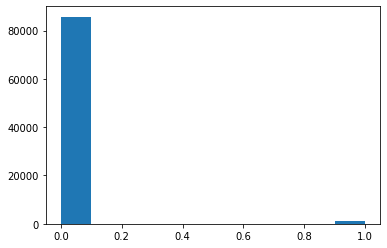

In [28]:
#Zmienna objaśniana
y = data['Disbursed']

plt.hist(y)
plt.show()

In [29]:
data

,ID,Gender,City,Monthly_Income,DOB,Lead_Creation_Date,Loan_Amount_Applied,Loan_Tenure_Applied,Existing_EMI,Employer_Name,...,EMI_Loan_Submitted,Filled_Form,Device_Type,Var2,Source,Var4,Disbursed,Age,Lead_Creation_Date_DayOfWeek,Lead_Creation_Date_Month
0,ID000002C20,Female,Delhi,20000,23-May-78,15-May-15,300000.0,5.0,0.0,Other,...,NaN,N,Web-browser,G,S122,1,0,36,4,5
1,ID000004E40,Male,Mumbai,35000,07-Oct-85,04-May-15,200000.0,2.0,0.0,TATA CONSULTANCY SERVICES LTD (TCS),...,6762.90,N,Web-browser,G,S122,3,0,29,0,5
2,ID000007H20,Male,Other,22500,10-Oct-81,19-May-15,600000.0,4.0,0.0,Other,...,NaN,N,Web-browser,B,S143,1,0,33,1,5
3,ID000008I30,Male,Other,35000,30-Nov-87,09-May-15,1000000.0,5.0,0.0,Other,...,NaN,N,Web-browser,B,S143,3,0,27,5,5
4,ID000009J40,Male,Bengaluru,100000,17-Feb-84,20-May-15,500000.0,2.0,25000.0,Other,...,NaN,N,Web-browser,B,S134,3,0,31,2,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87015,ID124813N30,Female,Other,71901,27-Nov-69,31-Jul-15,1000000.0,5.0,14500.0,Other,...,NaN,N,Web-browser,G,S122,3,0,-55,4,7
87016,ID124814O40,Female,Kochi,16000,01-Dec-90,31-Jul-15,0.0,0.0,0.0,Other,...,9425.76,Y,Mobile,G,S122,5,0,24,4,7
87017,ID124816Q10,Male,Bengaluru,118000,28-Jan-72,31-Jul-15,0.0,0.0,0.0,Other,...,NaN,N,Mobile,G,S122,3,0,43,4,7
87018,ID124818S30,Male,Bengaluru,98930,27-Apr-77,31-Jul-15,800000.0,5.0,13660.0,Other,...,NaN,N,Web-browser,G,S122,3,0,38,4,7


In [30]:
#Zmienne objaśniające
data_explanatory = data.drop(columns=['Disbursed', 'ID', 'DOB', 'Lead_Creation_Date'])

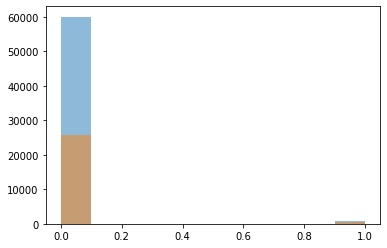

X_train.shape: (60914, 24) X_test.shape: (26106, 24)
Wartości y_train:
0    60035
1      879
Name: Disbursed, dtype: int64
Wartości y_test:
0    25712
1      394
Name: Disbursed, dtype: int64


In [31]:
#Podział na zbiór treningowy i zbiór testowy
X_train, X_test, y_train, y_test = train_test_split(data_explanatory, y, test_size=0.30, random_state=42)

plt.hist(y_train, alpha=0.5)
plt.hist(y_test, alpha=0.5)
plt.show()

print("X_train.shape: {} X_test.shape: {}".format(X_train.shape, X_test.shape))
print("Wartości y_train:")
print(y_train.value_counts())
print("Wartości y_test:")
print(y_test.value_counts())

In [32]:
X_train_values = X_train.values
X_train_columns = X_train.columns

In [33]:
X_train.head()

,Gender,City,Monthly_Income,Loan_Amount_Applied,Loan_Tenure_Applied,Existing_EMI,Employer_Name,Salary_Account,Mobile_Verified,Var5,...,Processing_Fee,EMI_Loan_Submitted,Filled_Form,Device_Type,Var2,Source,Var4,Age,Lead_Creation_Date_DayOfWeek,Lead_Creation_Date_Month
44277,Male,Chennai,28000,100000.0,2.0,2500.0,Other,Indian Bank,Y,9,...,1000.0,5089.58,Y,Web-browser,B,S133,5,28,5,6
5140,Female,Surat,14000,0.0,0.0,0.0,Other,Axis Bank,N,0,...,NaN,NaN,N,Mobile,C,S133,1,22,3,5
53345,Female,Mumbai,25000,0.0,0.0,0.0,Other,Kotak Bank,Y,1,...,NaN,NaN,N,Mobile,C,S143,3,28,1,6
38935,Male,Mumbai,40000,0.0,0.0,0.0,OCWEN FINANCIAL SOLUTIONS PVT LTD,Standard Chartered Bank,Y,9,...,4752.0,16519.73,Y,Mobile,C,S159,5,24,0,6
48480,Male,Delhi,22000,0.0,0.0,0.0,Other,State Bank of India,Y,2,...,NaN,NaN,N,Mobile,C,S133,2,34,2,6


In [34]:
#DataframeSelector zostanie wykorzystany, aby wybrać określone atrybuty ze zbioru danych (zmienne numeryczne albo kategoryczne)
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names]

In [35]:
#Atrybuty numeryczne
num_attributes = data_explanatory.select_dtypes(include='number')
print(num_attributes)
num_attributes_selected = num_attributes.drop(columns=['Loan_Tenure_Applied', 'Loan_Tenure_Submitted', 'Var4', 'Var5', 'Lead_Creation_Date_DayOfWeek', 'Lead_Creation_Date_Month'])
num_attributes_selected =list(num_attributes_selected.columns)
print(num_attributes_selected)

       Monthly_Income  Loan_Amount_Applied  Loan_Tenure_Applied  Existing_EMI  \
0               20000             300000.0                  5.0           0.0   
1               35000             200000.0                  2.0           0.0   
2               22500             600000.0                  4.0           0.0   
3               35000            1000000.0                  5.0           0.0   
4              100000             500000.0                  2.0       25000.0   
...               ...                  ...                  ...           ...   
87015           71901            1000000.0                  5.0       14500.0   
87016           16000                  0.0                  0.0           0.0   
87017          118000                  0.0                  0.0           0.0   
87018           98930             800000.0                  5.0       13660.0   
87019           42300                  0.0                  0.0           0.0   

       Var5  Loan_Amount_Su

In [36]:
#Pipeline dla atrybutów numerycznych
num_pipeline = Pipeline([
        ("select_numeric", DataFrameSelector(num_attributes_selected)),
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler())
    ])
num_pipeline.fit_transform(X_train)

array([[-2.34547090e-02, -3.67246197e-01, -2.69121880e-02, ...,
        -1.24117175e+00, -1.10946980e+00,  1.89875703e-01],
       [-3.72694403e-02, -6.50490953e-01, -7.99193726e-02, ...,
        -1.32202582e-01, -1.21843224e-01, -1.15885727e-01],
       [-2.64150086e-02, -6.50490953e-01, -7.99193726e-02, ...,
        -1.32202582e-01, -1.21843224e-01,  1.89875703e-01],
       ...,
       [-3.70523516e-02, -3.67246197e-01, -5.70931413e-03, ...,
        -1.32202582e-01, -1.21843224e-01,  8.01398561e-01],
       [-4.01024469e-02, -4.38057386e-01, -7.99193726e-02, ...,
        -1.32202582e-01, -1.21843224e-01,  6.48517847e-01],
       [ 3.68137027e-03, -6.50490953e-01, -7.99193726e-02, ...,
        -8.71885017e-01,  2.83635523e+00, -4.03982407e+00]])

In [37]:
#Atrybuty kategoryczne
cat_attributes = data_explanatory.select_dtypes(include='object')
print(cat_attributes)
cat_attributes_selected = cat_attributes#.drop(columns=[ ])
cat_attributes_selected = list(cat_attributes_selected.columns)
cat_attributes_selected.extend(['Loan_Tenure_Applied', 'Loan_Tenure_Submitted', 'Var4', 'Var5', 'Lead_Creation_Date_DayOfWeek', 'Lead_Creation_Date_Month'])
print(cat_attributes_selected)

       Gender       City                        Employer_Name  \
0      Female      Delhi                                Other   
1        Male     Mumbai  TATA CONSULTANCY SERVICES LTD (TCS)   
2        Male      Other                                Other   
3        Male      Other                                Other   
4        Male  Bengaluru                                Other   
...       ...        ...                                  ...   
87015  Female      Other                                Other   
87016  Female      Kochi                                Other   
87017    Male  Bengaluru                                Other   
87018    Male  Bengaluru                                Other   
87019    Male     Mumbai                  GOVERNMENT OF INDIA   

            Salary_Account Mobile_Verified  Var1 Filled_Form  Device_Type  \
0                HDFC Bank               N  HBXX           N  Web-browser   
1               ICICI Bank               Y  HBXA           N  Web

In [38]:
#Definiowanie uzupełniania braków danych dla zmiennych kategorycznych - uzupełnienie najczęściej występującą wartością
#Inspired from stackoverflow.com/questions/25239958
class MostFrequentImputer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        self.most_frequent_ = pd.Series([X[c].value_counts().index[0] for c in X],
                                        index=X.columns)
        return self
    def transform(self, X, y=None):
        return X.fillna(self.most_frequent_)

In [39]:
#Pipeline dla atrybutów kategorycznych
cat_pipeline = Pipeline([
        ("select_cat", DataFrameSelector(cat_attributes_selected)),
        ("imputer", MostFrequentImputer()),
        ("cat_encoder", OneHotEncoder(sparse = False)),
    ])
cat_pipeline.fit_transform(X_train)

array([[0., 1., 0., ..., 0., 1., 0.],
       [1., 0., 0., ..., 1., 0., 0.],
       [1., 0., 0., ..., 0., 1., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 1.],
       [1., 0., 0., ..., 1., 0., 0.],
       [0., 1., 0., ..., 1., 0., 0.]])

In [40]:
#Połączenie pipeline'ów: dla danych numerycznych i danych kategorycznych
preprocess_pipeline = FeatureUnion(transformer_list=[
        ("num_pipeline", num_pipeline),
        ("cat_pipeline", cat_pipeline),
    ])

In [41]:
#Walidacja krzyżowa
seed=123
kfold = StratifiedKFold(n_splits=5, random_state=seed, shuffle=True)

In [42]:
#Pipeline dla pierwszego modelu
pipe = Pipeline([('preprocessing', preprocess_pipeline), ('classifier', RandomForestClassifier())])

param_grid = {
            'classifier__min_samples_leaf': [10, 50, 100]
}

rfc = GridSearchCV(pipe, param_grid, cv=kfold, return_train_score=True, n_jobs=-1)

rfc.fit(X_train, y_train)
rfc.best_params_

{'classifier__min_samples_leaf': 10}

In [43]:
#Pipeline dla drugiego modelu
pipe = Pipeline([('preprocessing', preprocess_pipeline), ('classifier', xgb.XGBClassifier())])

param_grid = {
            'classifier__max_depth': [ 3, 6, 9]
}

xgb = GridSearchCV(pipe, param_grid, cv=kfold, return_train_score=True, n_jobs=-1)

xgb.fit(X_train, y_train)
xgb.best_params_

{'classifier__max_depth': 3}

In [44]:
#Pipeline dla trzeciego modelu
pipe = Pipeline([('preprocessing', preprocess_pipeline), ('classifier', LogisticRegression(max_iter=100000))])

param_grid = {
            'classifier__C': [0.5, 1, 1.5]
}

lr = GridSearchCV(pipe, param_grid, cv=kfold, return_train_score=True, n_jobs=-1)

lr.fit(X_train, y_train)
lr.best_params_

{'classifier__C': 0.5}

Random Forest
[[17421  8291]
 [   69   325]]


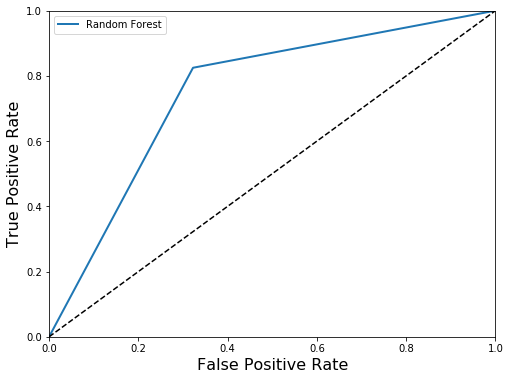

precision_score: 0.9815914034388965
recall_score: 0.6797671033478894
f1_score: 0.7954074225565418
accuracy_score: 0.6797671033478894
balanced_accuracy_score: 0.7512083279371026
roc_auc_score: 0.7512083279371027
XGBoost
[[18797  6915]
 [   81   313]]


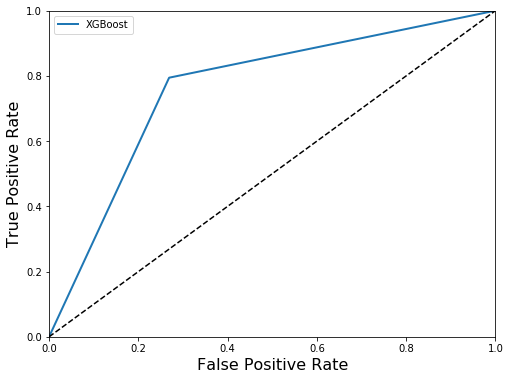

precision_score: 0.9813352869381112
recall_score: 0.7320156285911285
f1_score: 0.8316189875772321
accuracy_score: 0.7320156285911285
balanced_accuracy_score: 0.7627378355797447
roc_auc_score: 0.7627378355797447
Logistic regression
[[19077  6635]
 [  106   288]]


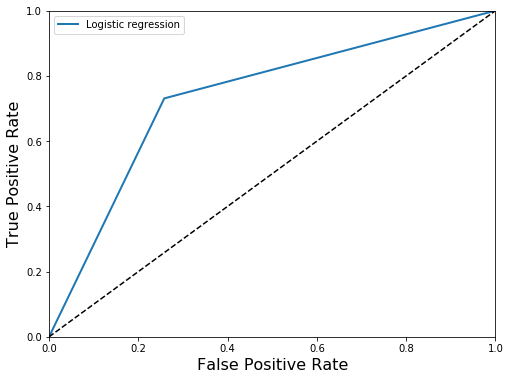

precision_score: 0.9800932014746019
recall_score: 0.7417834980464261
f1_score: 0.8382115287639873
accuracy_score: 0.7417834980464261
balanced_accuracy_score: 0.736456875692955
roc_auc_score: 0.7364568756929549


In [48]:
models = []
models.append(('Random Forest', rfc.best_estimator_))
models.append(('XGBoost', xgb.best_estimator_))
models.append(('Logistic regression', lr.best_estimator_))

precision_score = []
recall_score = []
f1_score = []
accuracy_score = []
balanced_accuracy_score = []
roc_auc_score = []
threshold = 0.015

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
    

for name, model in models:
    print(name)
    
    predicted_proba_test = model.predict_proba(X_test)
    predicted_test = (predicted_proba_test [:,1] >= threshold).astype('int')
    print(confusion_matrix(y_test, predicted_test))
    
    fpr, tpr, thresholds = roc_curve(y_true = y_test, y_score = predicted_test)
    
    plt.figure(figsize=(8, 6))
    plot_roc_curve(fpr, tpr, label=name)
    plt.legend()
    plt.show()
    
    print("precision_score: {}".format( metrics.precision_score(y_test, predicted_test, average='weighted') ))
    print("recall_score: {}".format( metrics.recall_score(y_test, predicted_test, average='weighted') ))
    print("f1_score: {}".format( metrics.f1_score(y_test, predicted_test, average='weighted') ))
    print("accuracy_score: {}".format( metrics.accuracy_score(y_test, predicted_test) ))
    print("balanced_accuracy_score: {}".format( metrics.balanced_accuracy_score(y_test, predicted_test) ))
    print("roc_auc_score: {}".format( metrics.roc_auc_score(y_test, predicted_test) ))
    
    precision_score.append(metrics.precision_score(y_test, predicted_test, average='weighted'))
    recall_score.append(metrics.recall_score(y_test, predicted_test, average='weighted'))
    f1_score.append(metrics.f1_score(y_test, predicted_test, average='weighted'))
    accuracy_score.append(metrics.accuracy_score(y_test, predicted_test))
    balanced_accuracy_score.append(metrics.balanced_accuracy_score(y_test, predicted_test))
    roc_auc_score.append(metrics.roc_auc_score(y_test , predicted_test))

In [49]:
import pandas as pd
d = {'precision_score': precision_score, 
     'recall_score': recall_score, 
     'f1_score': f1_score,
     'accuracy_score' : accuracy_score,
     'balanced_accuracy_score' : balanced_accuracy_score,
     'roc_auc_score' : roc_auc_score
    }
df = pd.DataFrame(data=d)
df.insert(loc=0, column='Method', value=['Random forest', 'XGBoost', 'Logistic regression'])
df

,Method,precision_score,recall_score,f1_score,accuracy_score,balanced_accuracy_score,roc_auc_score
0,Random forest,0.981591,0.679767,0.795407,0.679767,0.751208,0.751208
1,XGBoost,0.981335,0.732016,0.831619,0.732016,0.762738,0.762738
2,Logistic regression,0.980093,0.741783,0.838212,0.741783,0.736457,0.736457
